In [17]:
from __future__ import division, print_function, absolute_import

import os
import numpy as np
import pandas as pd
import cv2
import pickle
import imutils
from scipy import misc
import h5py
import tensorflow as tf
 

assessor_land_image_path = '/Users/sam/All-Program/App-DataSet/HouseClassification/input_images/assessor_images/land'
assessor_house_image_path = '/Users/sam/All-Program/App-DataSet/HouseClassification/input_images/assessor_images/house'
aerial_land_image_path = '/Users/sam/All-Program/App-DataSet/HouseClassification/input_images/aerial_images/google/land'
aerial_house_image_path = '/Users/sam/All-Program/App-DataSet/HouseClassification/input_images/aerial_images/google/house'
overlayed_land_image_path = '/Users/sam/All-Program/App-DataSet/HouseClassification/input_images/overlayed_images/google/land'
overlayed_house_image_path = '/Users/sam/All-Program/App-DataSet/HouseClassification/input_images/overlayed_images/google/house'

label_dict = {'0': 'land', '1': 'house'}

## PREPROCESSING AND DATA PREP STUFF

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
def vizualize(imageArray, title_arr, data_type, rows, columns, figsize=(40, 6)):
    fig1, axs = plt.subplots(rows,columns, figsize=figsize, facecolor='y', edgecolor='k')
    if columns>1:
        axs = axs.ravel()
    for no, (image, title) in enumerate(zip(imageArray, title_arr)):
        axs[no].imshow(np.array(image, dtype=data_type))
        axs[no].set_title(title)

In [30]:
def image_transform(path_arr):
    image_arr = []
    for img in path_arr:  
        image = misc.imread(img)
#         if type(img).__module__ == 'numpy':    
        image = misc.imresize(image, [224,224])
        image_arr.append(image)
    return image_arr

def zero_pad(inp, crop_img_shape, out_shape):
    '''
    :param inp:
    :param out_shape:
    :return:

    One image at a time
    '''
    m, n, c = crop_img_shape#inp.get_shape().as_list()
    out_m, out_n, out_c = out_shape

    to_pad_m = max(out_m - m, 0)
    to_pad_n = max(out_n - n, 0)
    to_pad_c = max(out_c - c, 0)
    
    pad_m1 = to_pad_m // 2
    pad_m2 = to_pad_m - pad_m1
    
    pad_n1 = to_pad_n // 2
    pad_n2 = to_pad_n - pad_n1
    
    pad_c1 = to_pad_c // 2
    pad_c2 = to_pad_c - pad_c1
    
    paddings = tf.constant([[pad_m1, pad_m2], [pad_n1, pad_n2], [pad_c1, pad_c2]])
    inp = tf.pad(inp, paddings, 'CONSTANT')
    return inp

def crop_and_pad(inp_img_shape, crop_img_shape, out_img_shape):
    imgIN = tf.placeholder(dtype=tf.float32, shape=inp_img_shape)
    if len(crop_img_shape) != 0:
        imageOUT = tf.image.central_crop(imgIN, crop_img_shape[0]/inp_img_shape[0])
    else:
        imageOUT = imgIN
        crop_img_shape = inp_img_shape
    imageOUT1 = zero_pad(imageOUT, crop_img_shape, out_img_shape)
    return imgIN, imageOUT1

# OVERLAYED IMAGES:
---------

### SHOULD BE PREDICTED AS LAND

In [50]:
overlayed_land_pins = ['20-06-402-017-0000',
 '20-19-122-031-0000',
 '14-30-409-094-0000',
 '16-01-409-024-0000',
 '20-29-429-029-0000',
 '17-35-102-033-0000',
 '20-11-311-033-0000',
 '14-20-323-068-0000',
 '17-05-107-044-0000',
 '16-24-207-075-0000',
 '13-36-221-022-0000',
 '21-31-103-037-0000',
 '20-16-202-080-0000',
 '20-21-411-038-0000',
 '19-03-407-040-0000',
 '17-04-413-020-0000',
 '20-08-115-017-0000',
 '20-25-424-034-0000',
 '20-21-315-037-0000',
 '13-33-110-073-0000',
 '20-29-207-014-0000',
 '20-19-128-014-0000',
 '16-15-414-011-0000',
 '13-24-314-055-0000',
 '13-09-124-021-0000',
 '20-33-123-012-0000',
 '17-22-302-043-0000',
 '20-22-200-002-0000']

overlayed_house_pins = ['19-25-317-004-0000',
 '20-08-122-031-0000',
 '17-16-128-007-1011',
 '16-10-416-028-0000',
 '21-31-325-027-0000',
 '17-09-406-054-1029',
 '16-10-327-015-0000',
 '10-36-204-024-0000',
 '17-34-113-020-0000',
 '14-16-300-032-1325',
 '16-11-222-026-0000',
 '20-18-419-021-0000',
 '20-07-323-016-0000',
 '17-32-226-014-0000',
 '17-04-220-098-1168',
 '17-10-400-031-1428',
 '20-20-322-008-0000',
 '21-31-310-026-0000']

print (len(overlayed_land_pins), len(overlayed_house_pins))

28 18


In [44]:
overlayed_land_pins_path = [os.path.join(overlayed_land_image_path, pins+'.jpg') for pins in overlayed_land_pins]
aerial_land_pins_path = [os.path.join(aerial_land_image_path, pins+'.jpg') for pins in overlayed_land_pins]

overlayed_land_img_arr = image_transform(overlayed_land_pins_path)
aerial_land_img_arr = image_transform(aerial_land_pins_path)

tf.reset_default_graph()
imgIN, imgOUT = crop_and_pad(inp_img_shape=[224,224,3], crop_img_shape=[96,96,3], out_img_shape=[224,224,3])

overlayed_croppad_img_arr = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for img in overlayed_land_img_arr:
        overlayed_croppad_img_arr.append(sess.run(imgOUT, feed_dict={imgIN:img}))
        
aerial_croppad_img_arr = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for img in aerial_land_img_arr:
        aerial_croppad_img_arr.append(sess.run(imgOUT, feed_dict={imgIN:img}))

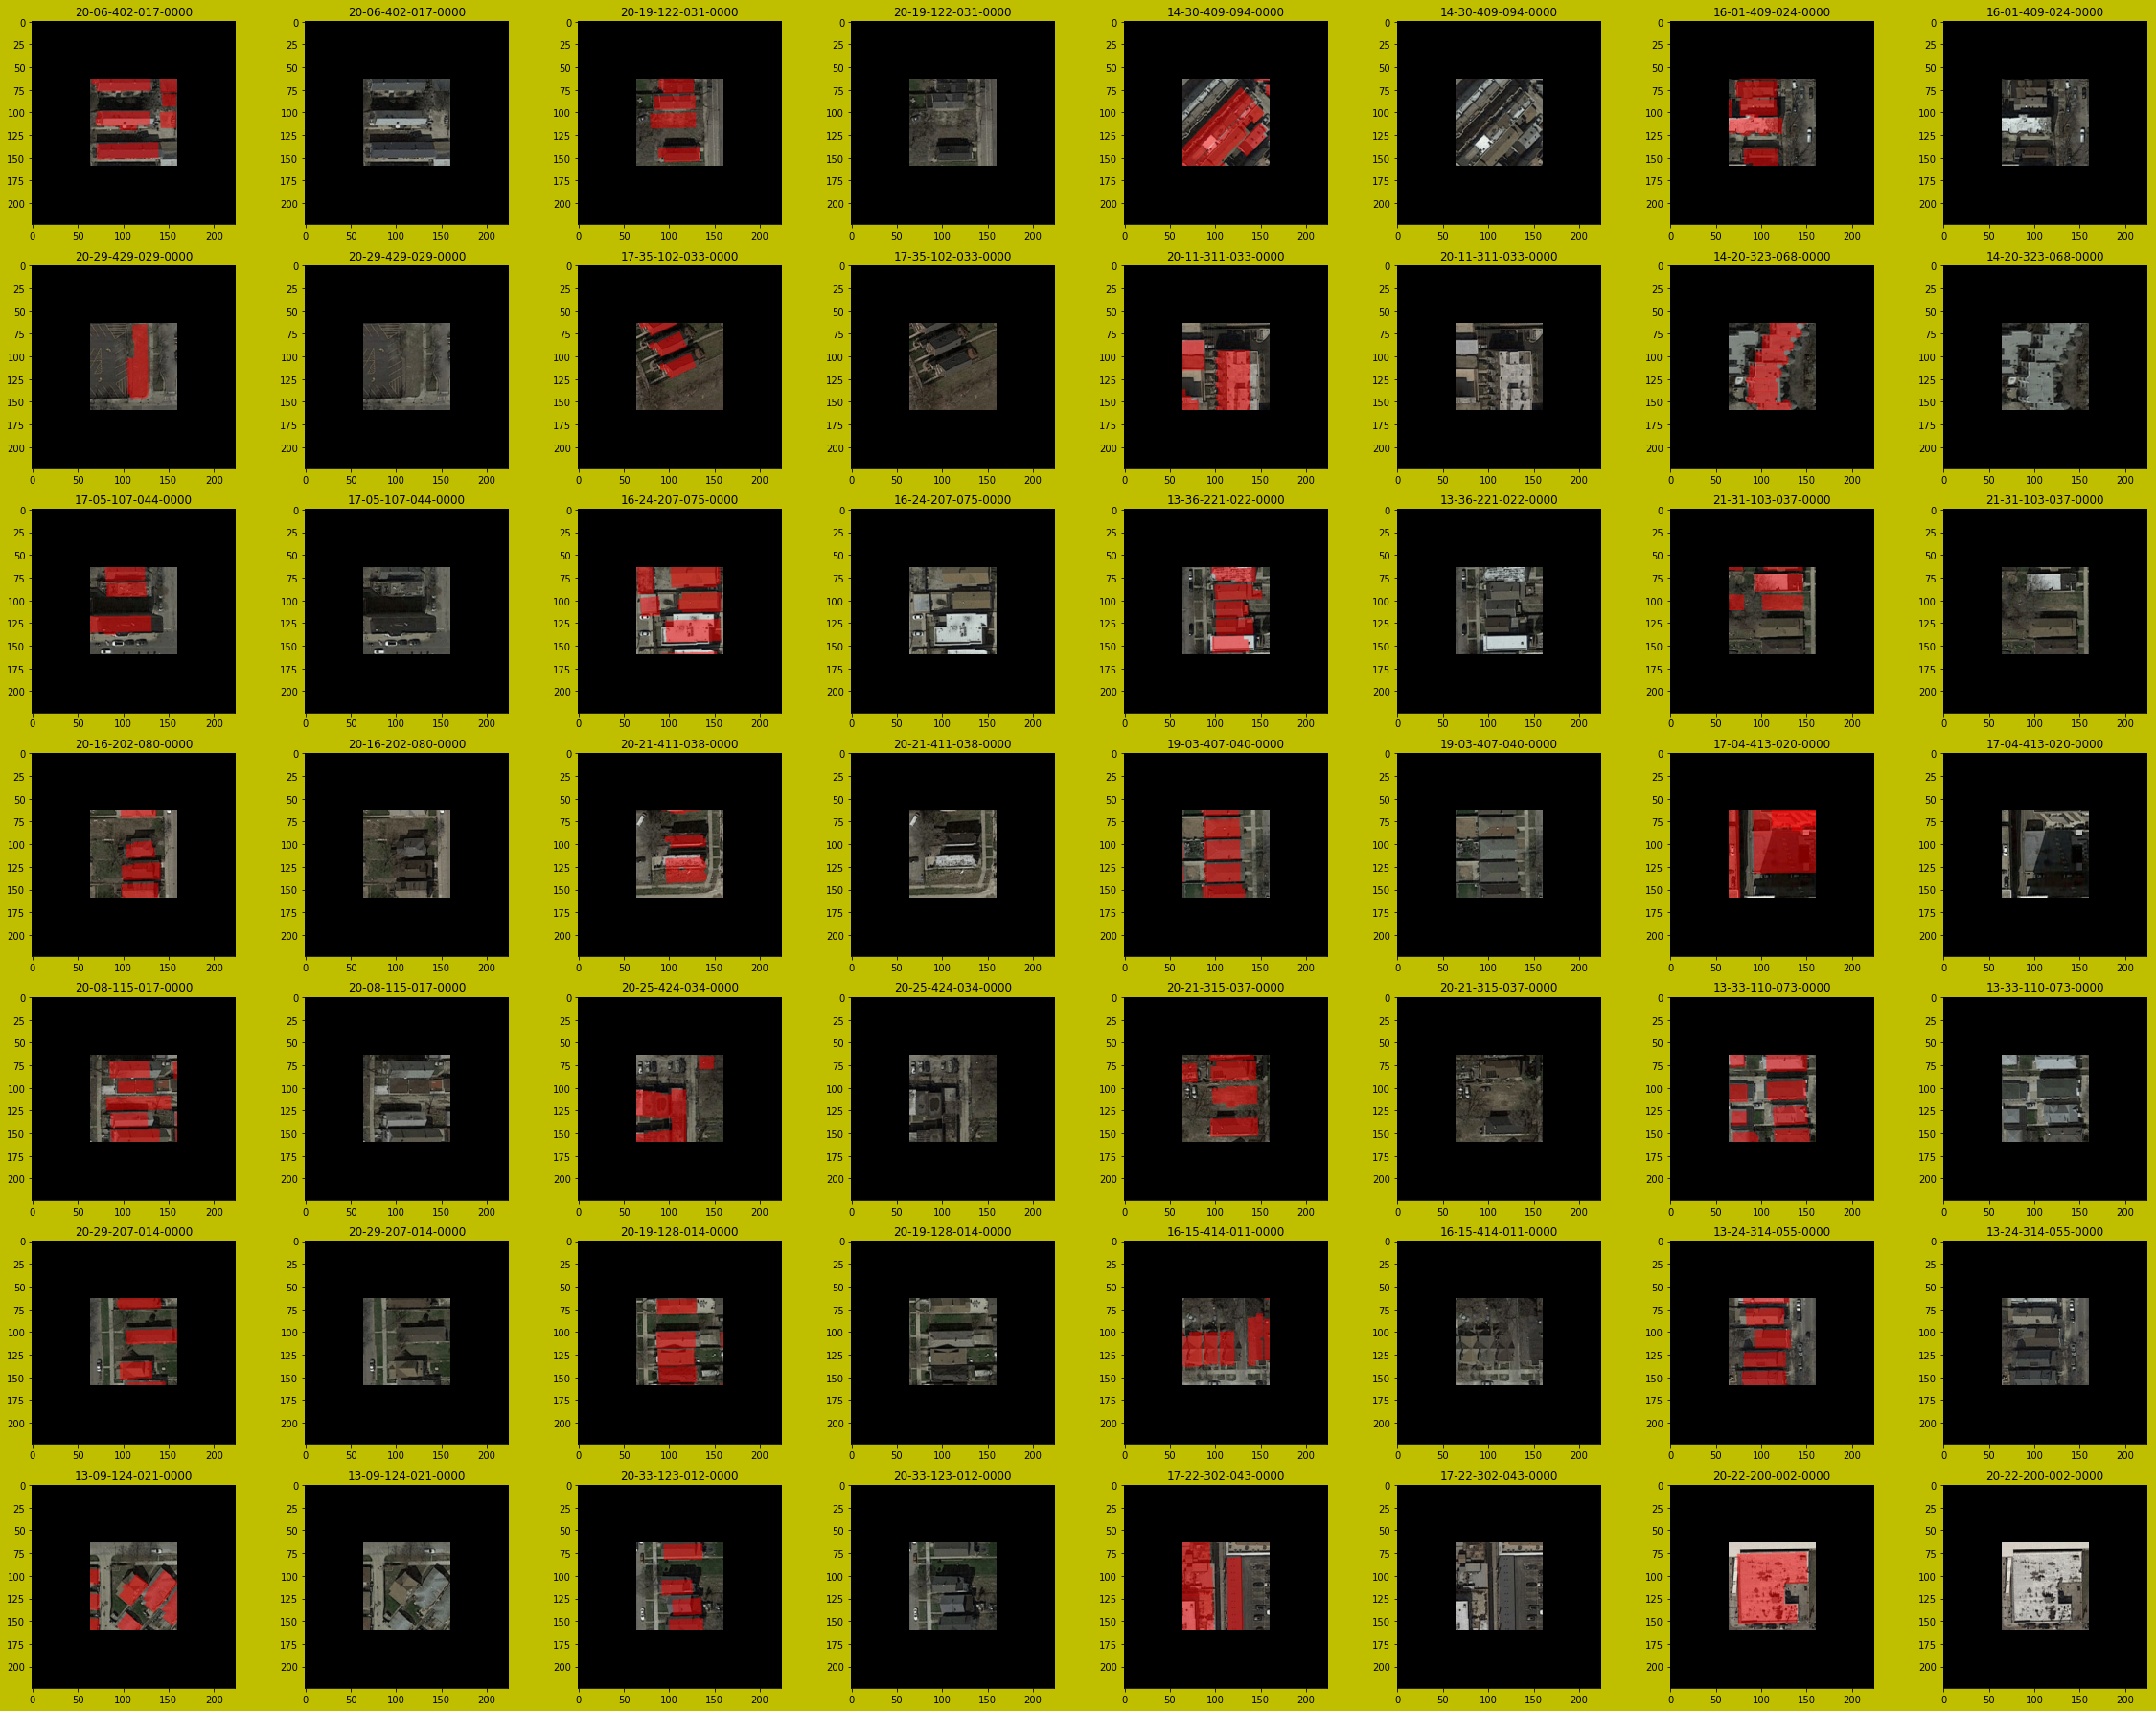

In [47]:
overlayed_aerial_img_arr = []
overlayed_aerial_land_pins = []
for i, (a, b) in enumerate(zip(overlayed_croppad_img_arr, aerial_croppad_img_arr)):
    overlayed_aerial_img_arr.append(a)
    overlayed_aerial_img_arr.append(b)
    overlayed_aerial_land_pins.append(overlayed_land_pins[i])
    overlayed_aerial_land_pins.append(overlayed_land_pins[i])
    
vizualize(overlayed_aerial_img_arr, overlayed_aerial_land_pins, data_type='uint8', rows=7, columns=8, figsize=(40, 32))

### SHOULD BE PREDICTED AS HOUSE

In [57]:
overlayed_house_pins_path = [os.path.join(overlayed_house_image_path, pins+'.jpg') for pins in overlayed_house_pins]
aerial_house_pins_path = [os.path.join(aerial_house_image_path, pins+'.jpg') for pins in overlayed_house_pins]

overlayed_house_img_arr = image_transform(overlayed_house_pins_path)
aerial_house_img_arr = image_transform(aerial_house_pins_path)

tf.reset_default_graph()
imgIN, imgOUT = crop_and_pad(inp_img_shape=[224,224,3], crop_img_shape=[96,96,3], out_img_shape=[224,224,3])

overlayed_croppad_img_arr = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for img in overlayed_house_img_arr:
        overlayed_croppad_img_arr.append(sess.run(imgOUT, feed_dict={imgIN:img}))
        
aerial_croppad_img_arr = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for img in aerial_house_img_arr:
        aerial_croppad_img_arr.append(sess.run(imgOUT, feed_dict={imgIN:img}))

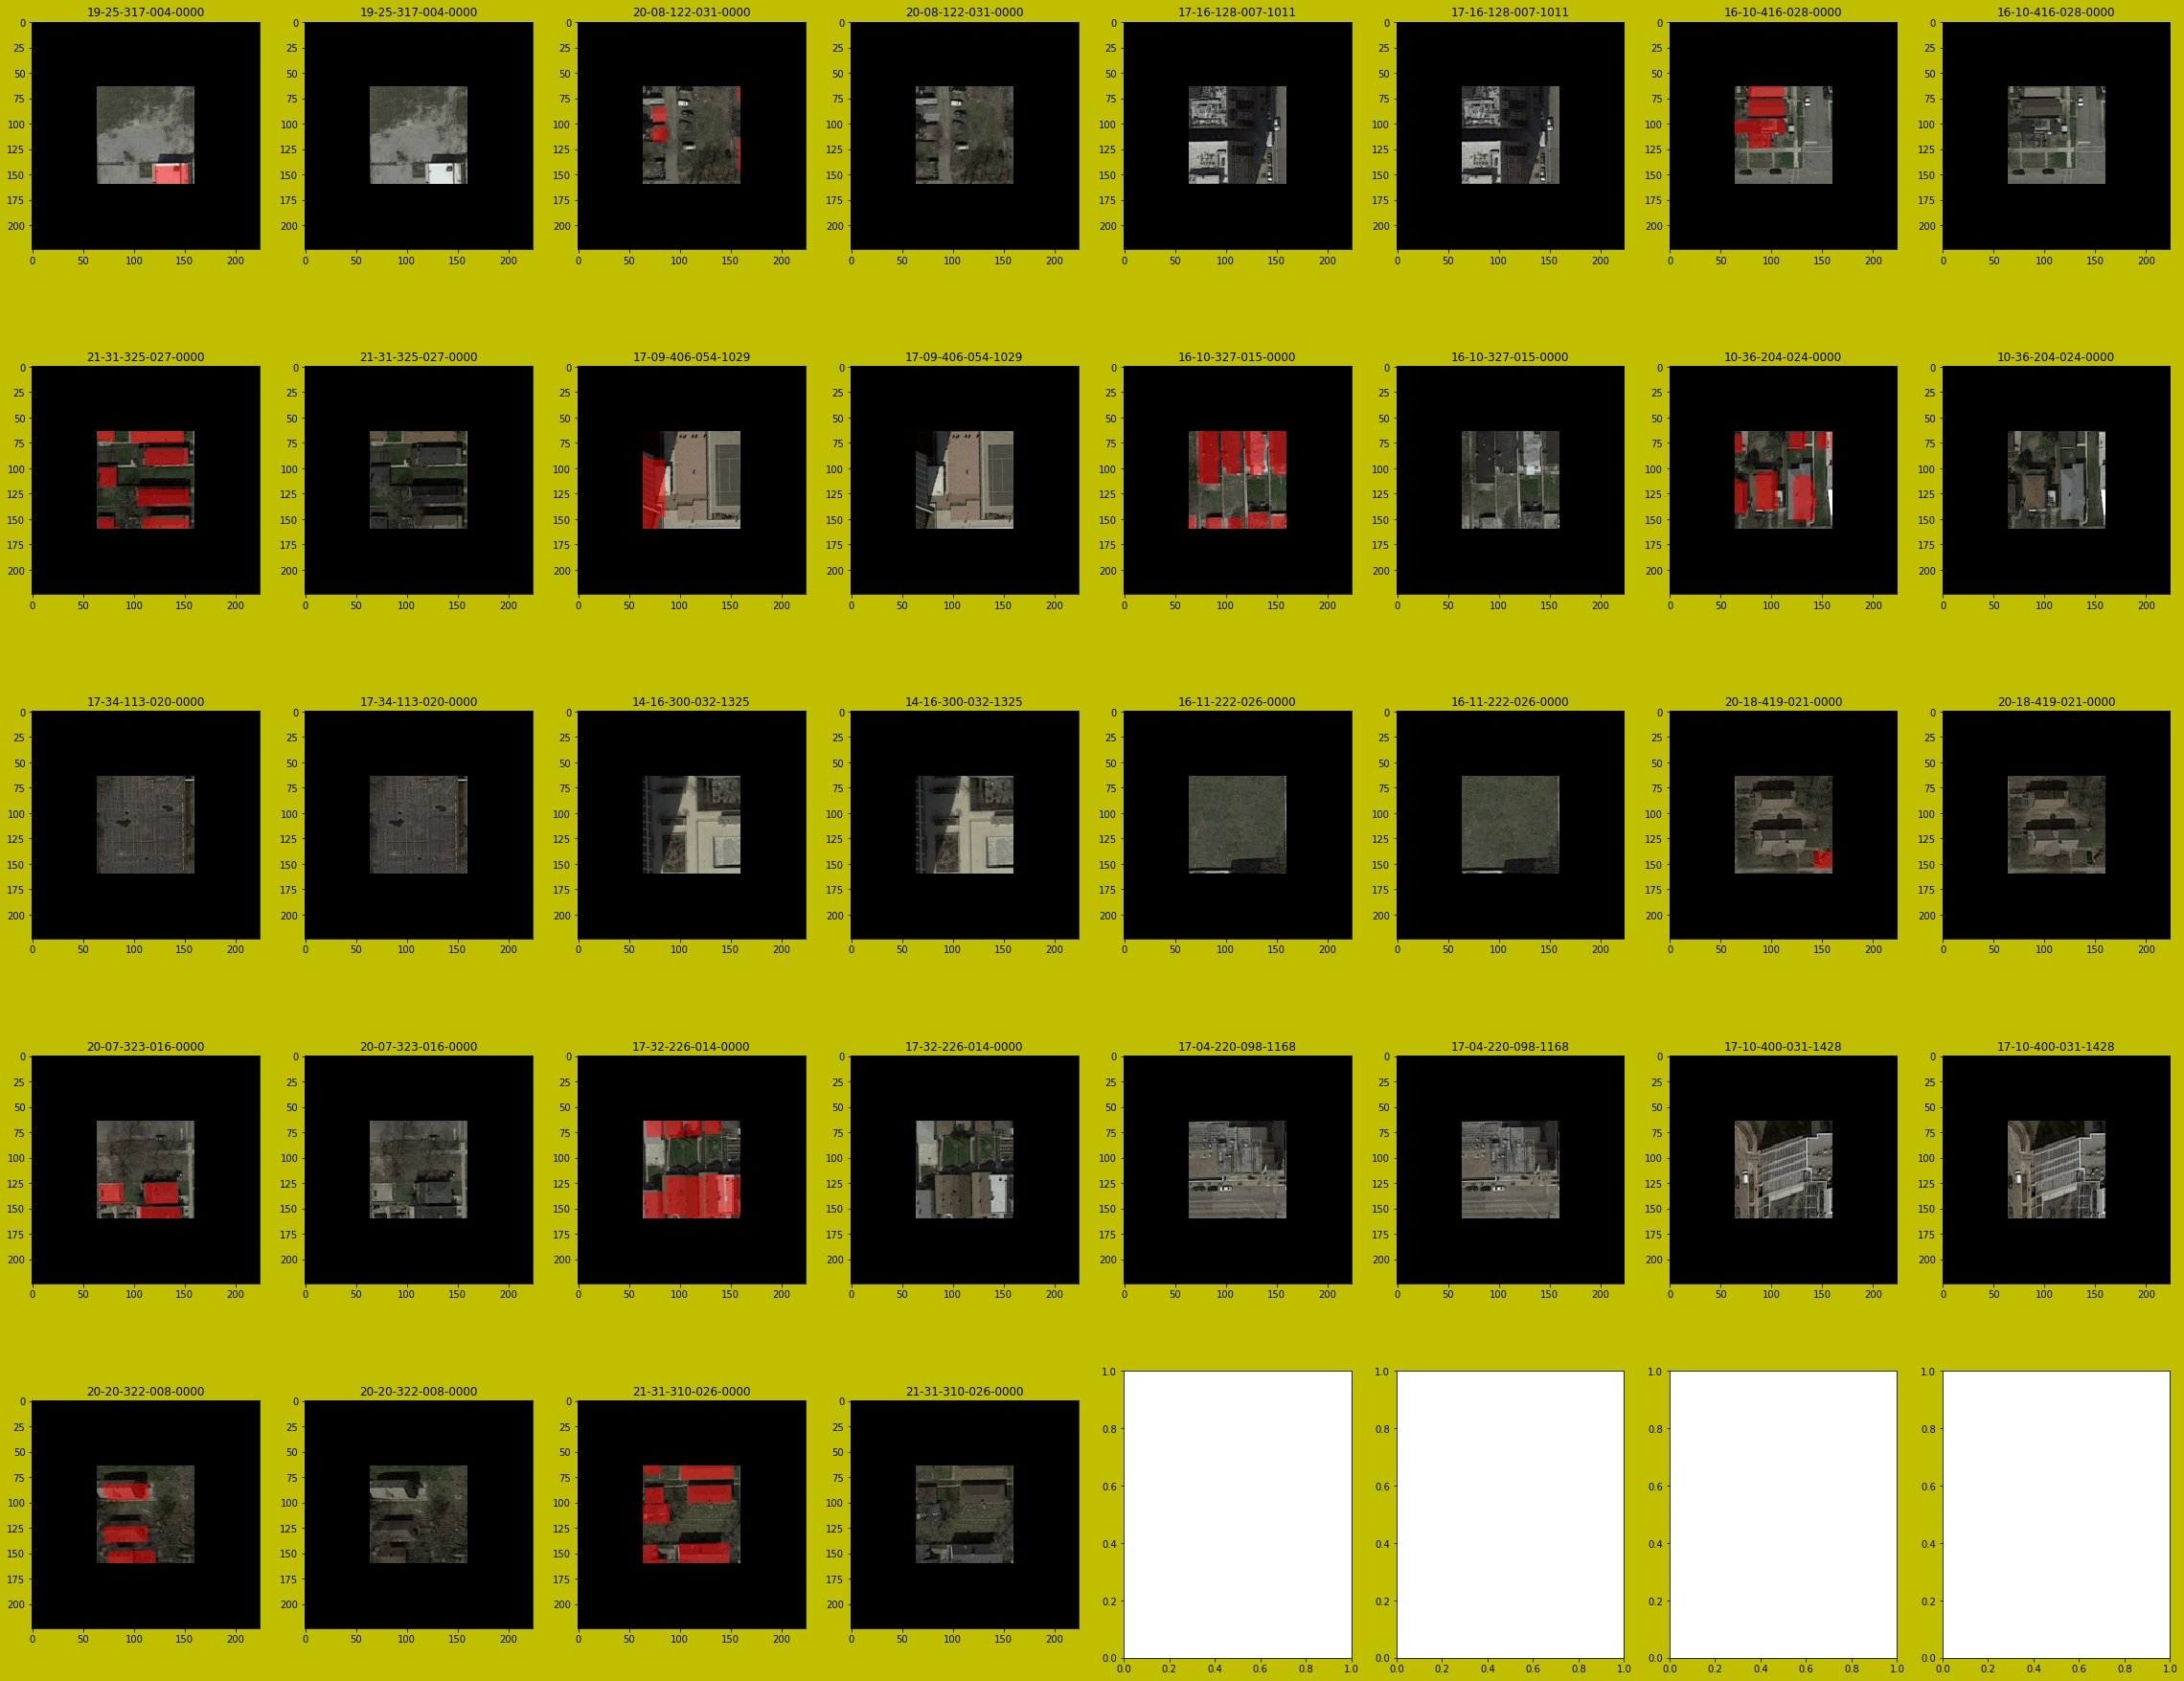

In [61]:
overlayed_aerial_img_arr = []
overlayed_aerial_house_pins = []
for i, (a, b) in enumerate(zip(overlayed_croppad_img_arr, aerial_croppad_img_arr)):
    overlayed_aerial_img_arr.append(a)
    overlayed_aerial_img_arr.append(b)
    overlayed_aerial_house_pins.append(overlayed_house_pins[i])
    overlayed_aerial_house_pins.append(overlayed_house_pins[i])
    
vizualize(overlayed_aerial_img_arr, overlayed_aerial_house_pins, data_type='uint8', rows=5, columns=8, figsize=(40, 32))

# AERIAL IMAGES:
--------

In [73]:
aerial_land_pins = ['20-06-402-017-0000',
 '14-31-321-060-0000',
 '20-17-105-026-0000',
 '20-33-310-038-0000',
 '16-01-409-024-0000',
 '16-35-411-030-0000',
 '17-35-102-033-0000',
 '20-17-221-007-0000',
 '20-17-115-038-0000',
 '16-24-207-075-0000',
 '13-36-221-022-0000',
 '20-07-205-041-0000',
 '16-26-326-005-0000',
 '16-14-328-023-0000',
 '20-07-406-002-0000',
 '20-20-305-039-0000',
 '13-32-125-002-0000',
 '20-21-411-038-0000',
 '17-06-107-054-0000',
 '19-03-407-040-0000',
 '20-16-213-016-0000',
 '17-04-413-020-0000',
 '16-23-114-023-0000',
 '20-08-115-017-0000',
 '20-25-424-034-0000',
 '20-20-323-026-0000',
 '20-21-315-037-0000',
 '13-33-110-073-0000',
 '16-13-304-020-0000',
 '16-09-402-025-0000',
 '20-19-128-014-0000',
 '17-34-320-016-0000',
 '16-15-414-011-0000',
 '13-24-314-055-0000',
 '20-06-418-019-0000',
 '16-14-403-024-0000',
 '16-09-224-004-0000',
 '13-09-124-021-0000',
 '20-33-123-012-0000',
 '20-08-413-037-0000',
 '16-15-308-024-0000',
 '20-09-328-006-0000',
 '20-05-303-022-0000']

aerial_house_pins = ['11-30-315-004-0000',
 '19-25-317-004-0000',
 '20-18-422-027-0000',
 '20-08-122-031-0000',
 '19-21-111-015-0000',
 '10-32-102-063-0000',
 '17-16-128-007-1315',
 '17-30-105-025-0000',
 '20-35-124-014-0000',
 '14-16-300-027-1035',
 '20-19-128-037-0000',
 '20-20-424-021-0000',
 '17-16-128-007-1011',
 '16-15-411-026-0000',
 '20-20-225-042-0000',
 '19-25-317-005-0000',
 '21-31-325-027-0000',
 '20-28-311-015-0000',
 '20-21-322-010-0000',
 '20-28-201-014-0000',
 '20-18-112-004-0000',
 '20-36-317-004-0000',
 '16-15-217-045-0000',
 '20-20-320-003-0000',
 '20-17-303-012-0000',
 '10-36-204-024-0000',
 '20-17-311-026-0000',
 '20-07-110-012-0000',
 '20-08-110-001-0000',
 '20-23-420-002-0000',
 '17-34-113-020-0000',
 '13-32-302-036-0000',
 '20-09-308-045-0000',
 '20-16-318-032-0000',
 '13-25-116-022-0000',
 '20-19-330-043-0000',
 '20-18-206-024-0000',
 '20-20-400-003-0000',
 '14-16-300-032-1325',
 '16-11-222-026-0000',
 '16-15-124-008-0000',
 '20-19-309-027-0000',
 '16-15-102-032-0000',
 '21-30-417-052-1013',
 '20-26-305-002-0000',
 '20-18-419-021-0000',
 '20-07-323-016-0000',
 '17-32-226-014-0000',
 '14-07-106-004-0000',
 '14-06-110-087-1003',
 '19-24-112-034-0000',
 '20-30-429-002-0000',
 '20-29-114-018-0000',
 '20-22-203-033-0000',
 '20-20-401-005-0000',
 '20-16-201-004-0000',
 '11-30-307-217-1004',
 '20-20-322-008-0000',
 '16-22-110-033-0000']

print (len(aerial_land_pins), len(aerial_house_pins))

43 59


## SHOULD BE PREDICTED AS LAND

In [81]:
aerial_land_pins_path = [os.path.join(aerial_land_image_path, pins+'.jpg') for pins in aerial_land_pins]
aerial_land_img_arr = image_transform(aerial_land_pins_path)

tf.reset_default_graph()
imgIN, imgOUT = crop_and_pad(inp_img_shape=[224,224,3], crop_img_shape=[96,96,3], out_img_shape=[224,224,3])

aerial_croppad_img_arr = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for img in aerial_land_img_arr:
        aerial_croppad_img_arr.append(sess.run(imgOUT, feed_dict={imgIN:img}))

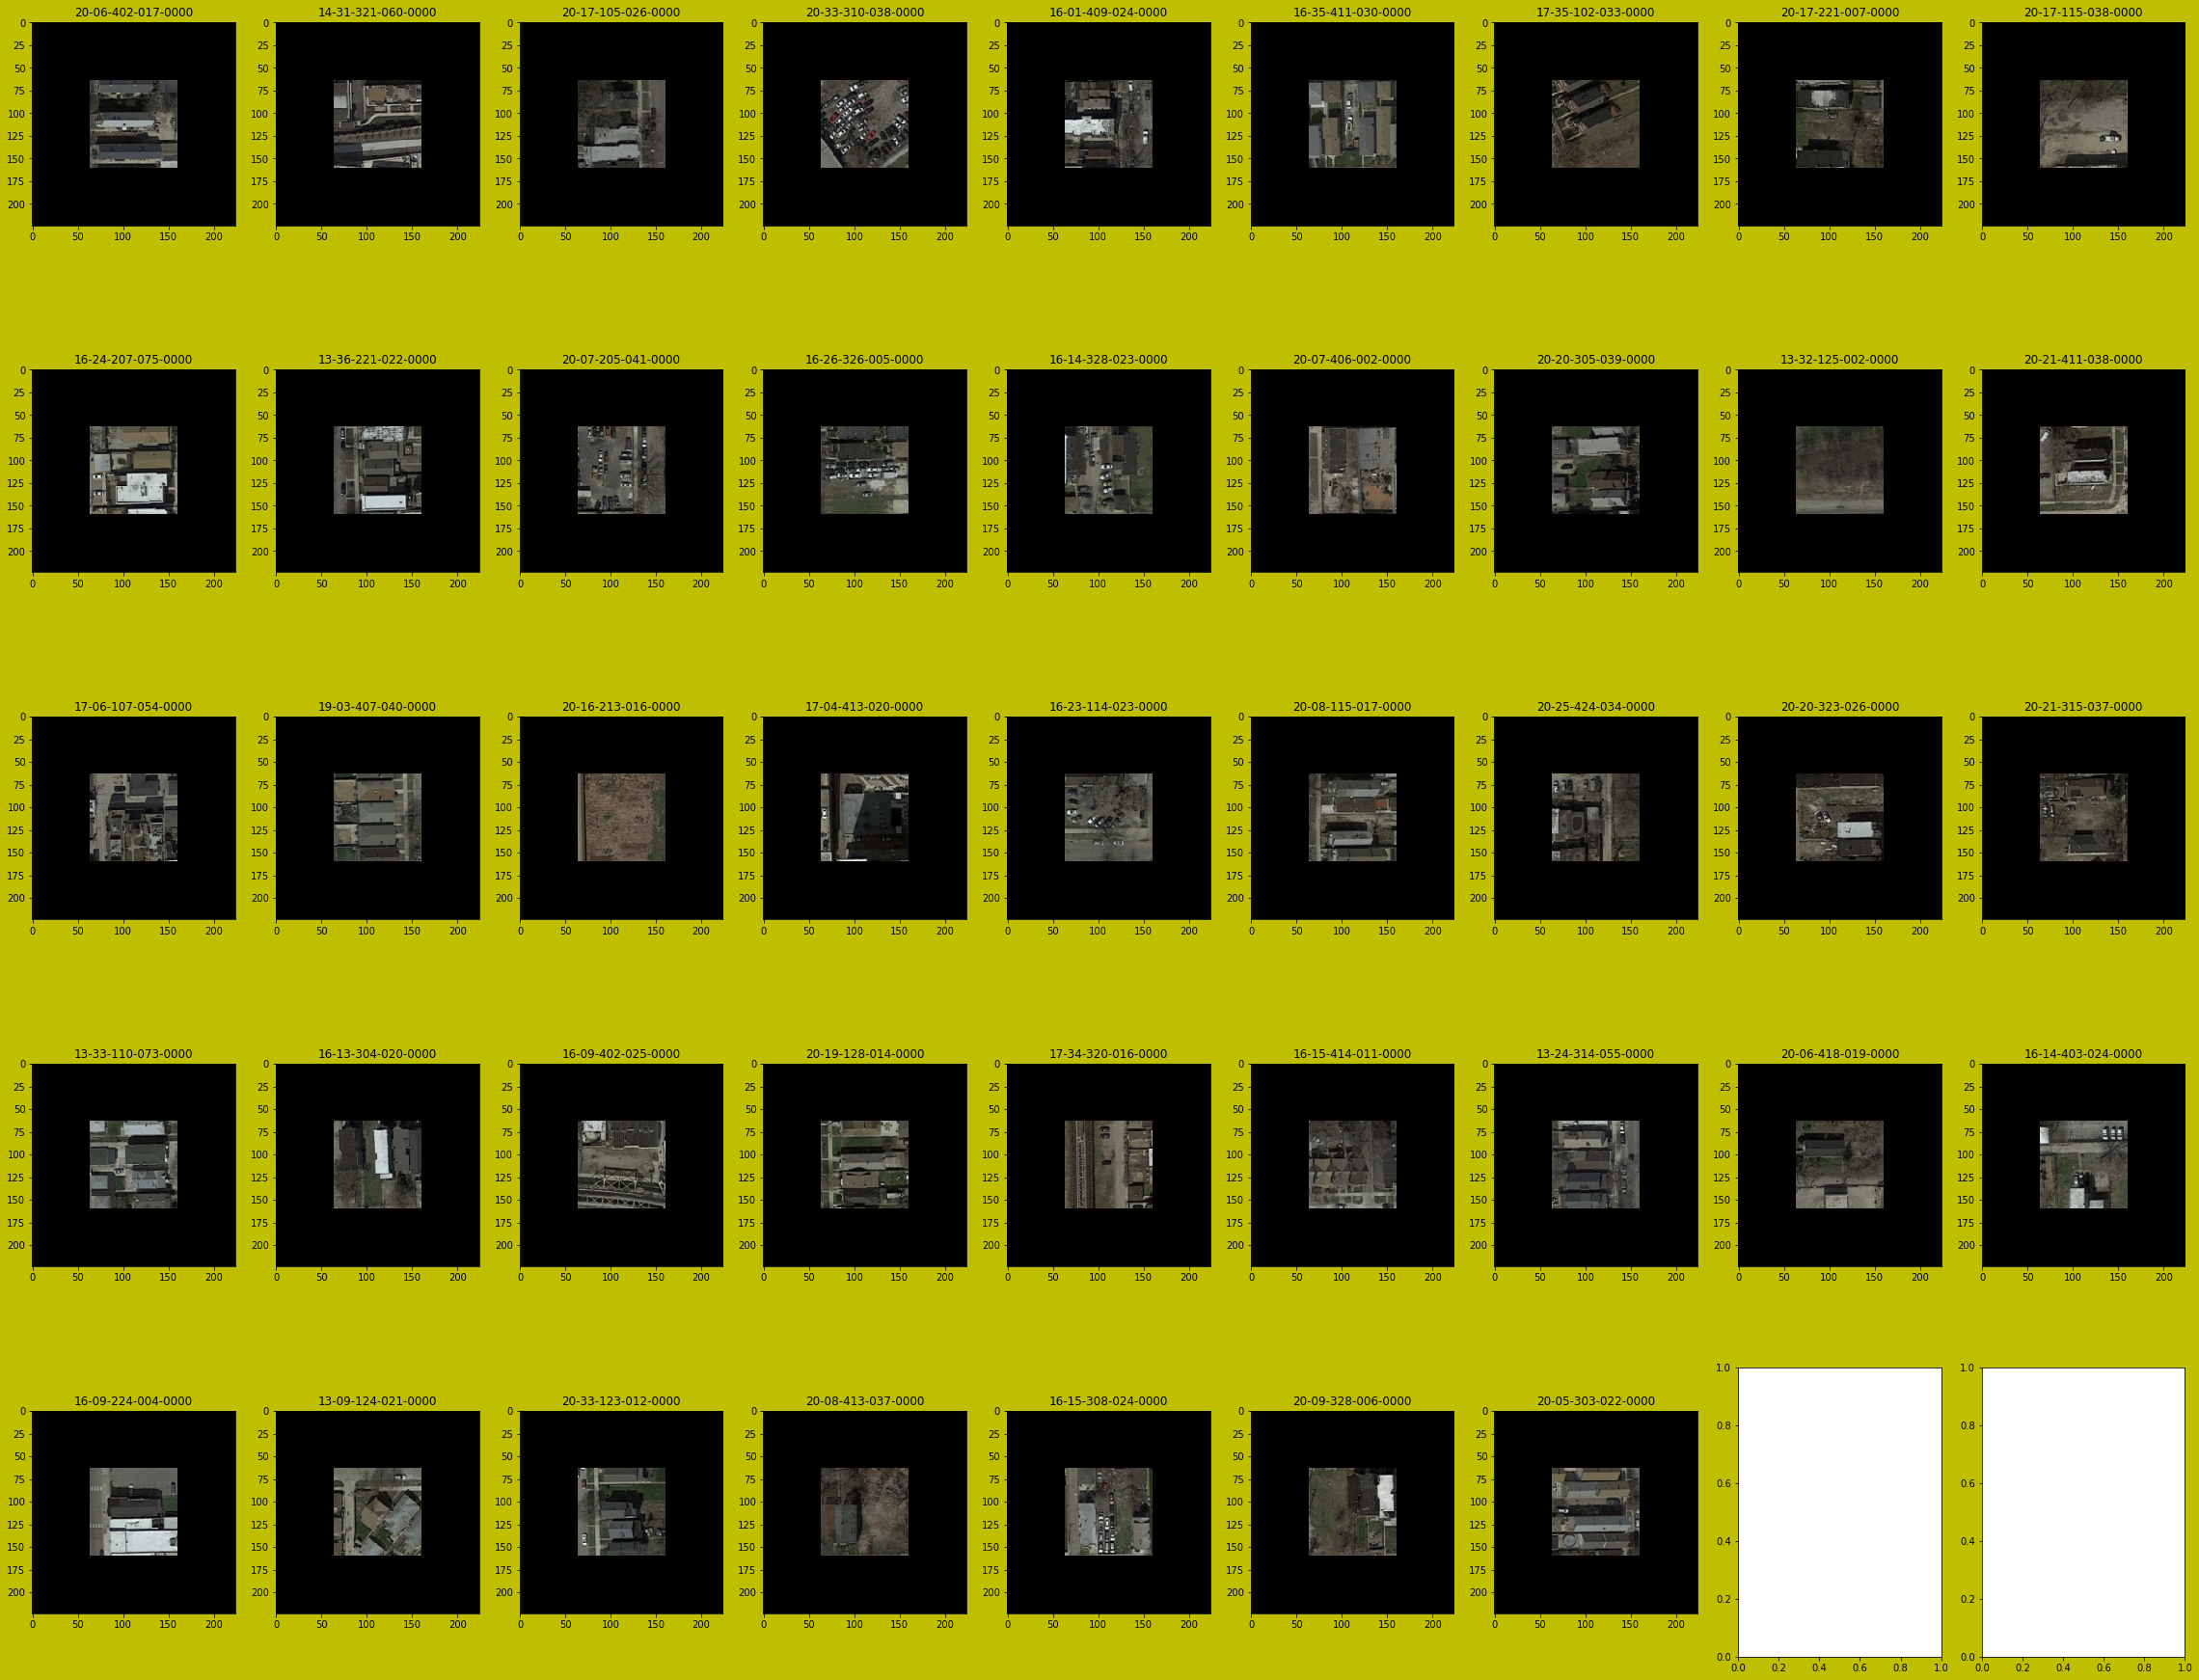

In [82]:
vizualize(aerial_croppad_img_arr, aerial_land_pins, data_type='uint8', rows=5, columns=9, figsize=(40, 32))

## SHOULD BE PREDICTED AS HOUSE

In [76]:
aerial_house_pins_path = [os.path.join(aerial_house_image_path, pins+'.jpg') for pins in aerial_house_pins]
aerial_house_img_arr = image_transform(aerial_house_pins_path)

tf.reset_default_graph()
imgIN, imgOUT = crop_and_pad(inp_img_shape=[224,224,3], crop_img_shape=[96,96,3], out_img_shape=[224,224,3])

aerial_croppad_img_arr = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for img in aerial_house_img_arr:
        aerial_croppad_img_arr.append(sess.run(imgOUT, feed_dict={imgIN:img}))

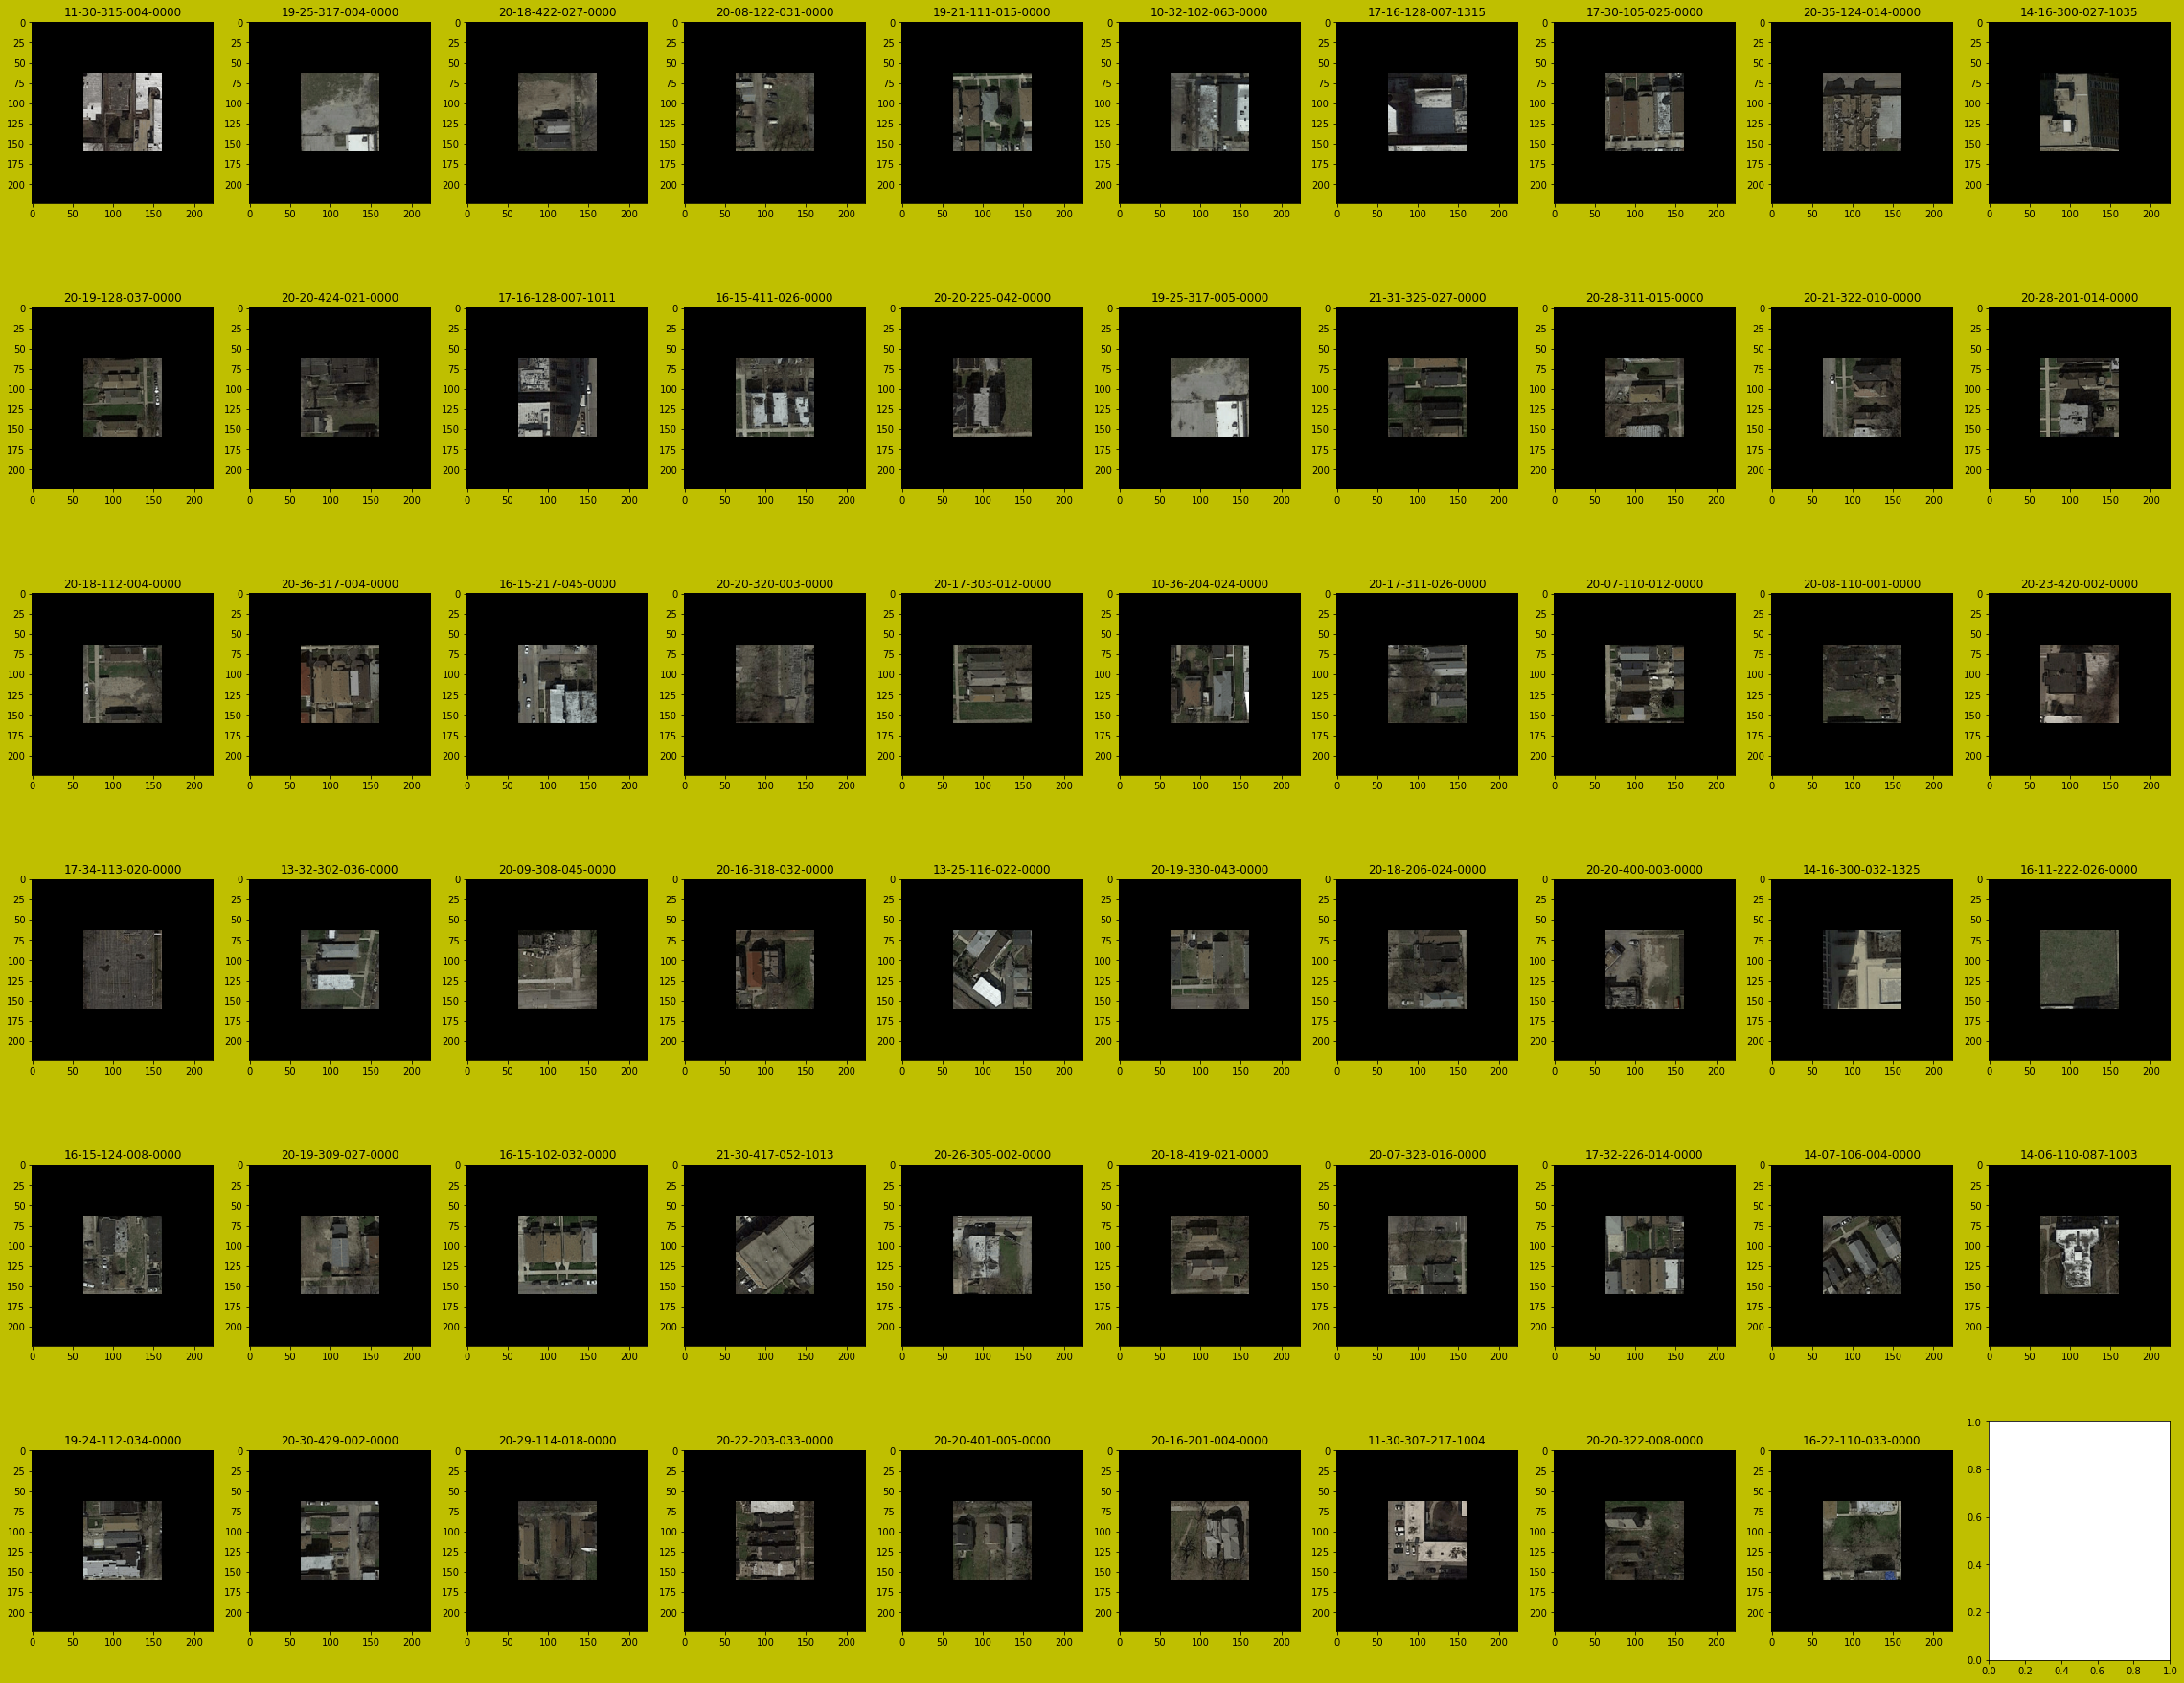

In [79]:
vizualize(aerial_croppad_img_arr, aerial_house_pins, data_type='uint8', rows=6, columns=10, figsize=(40, 32))